**Review**

Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did an excellent job! The project is accepted. Good luck on the final sprint!

# Initialization

# Project Description

The supermarket chain Good Seed would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage. You are asked to conduct that evaluation, so as you set to work, keep the following in mind: The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol. Computer vision methods can be used to determine age of a person from a photo. The task then is to build and evaluate a model for verifying people's age To start working on the task, you'll have a set of photographs of people with their ages indicated.

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [1]:
import pandas as pd
import numpy as np

In [2]:
#loading the data
df_face = pd.read_csv('/datasets/faces/labels.csv')
df_face.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
df_face.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
df_face.isnull().sum()

file_name    0
real_age     0
dtype: int64

In [5]:
df_face.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


## EDA

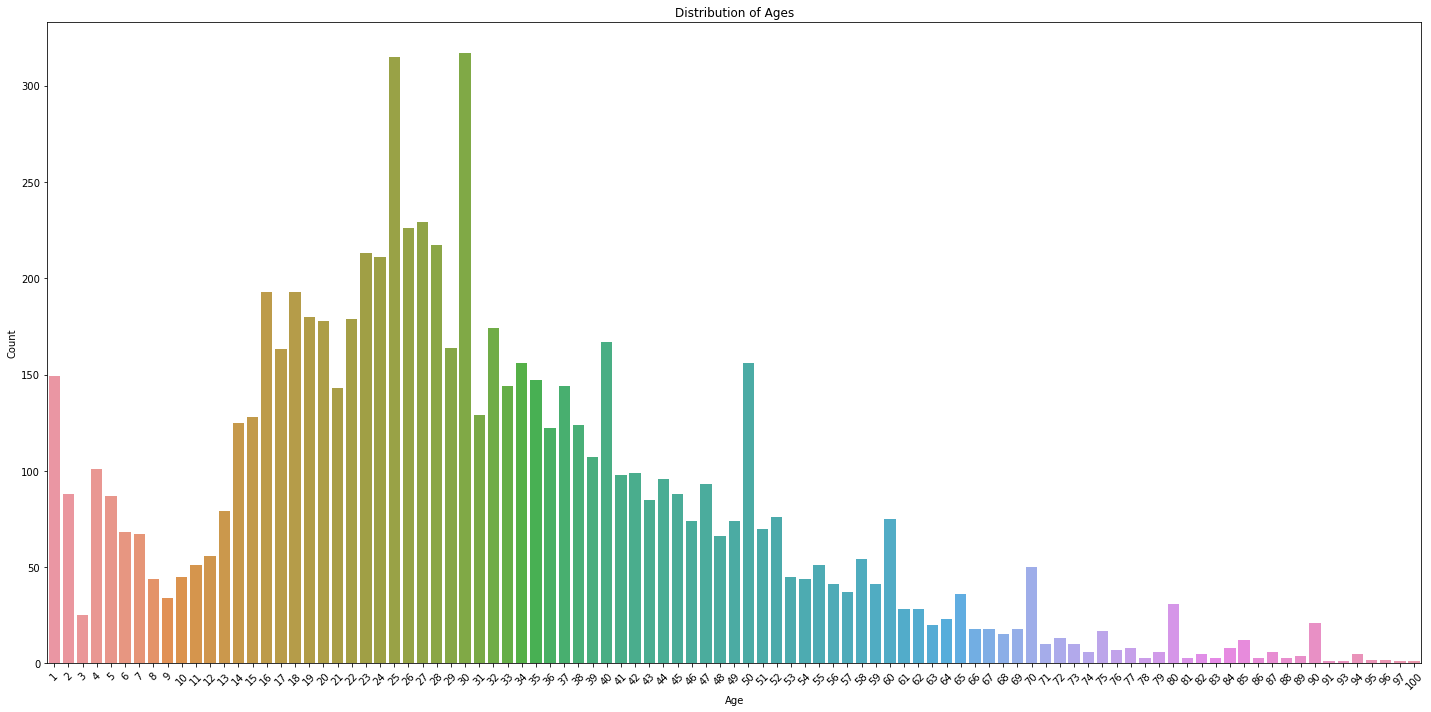

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

age_grp = df_face['real_age'].value_counts()
plt.figure(figsize=(20,10))
sns.barplot(x=age_grp.index, y=age_grp.values)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Ages')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

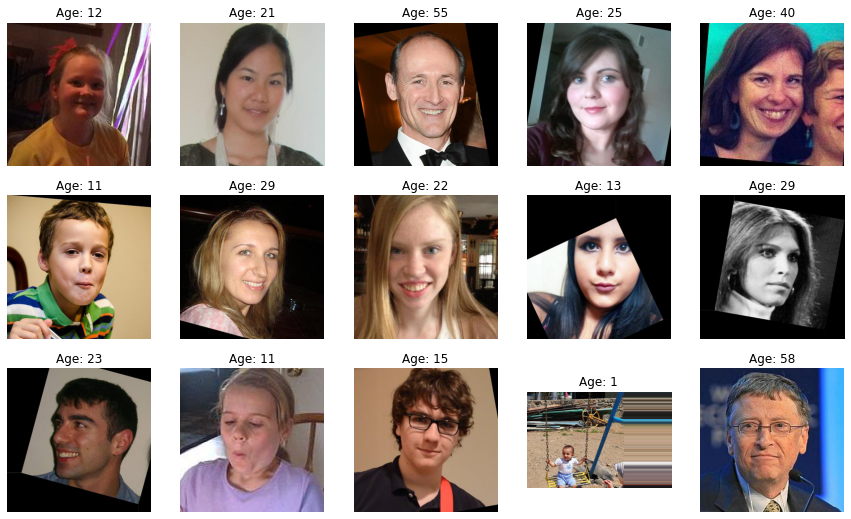

In [7]:
import os
from PIL import Image

images_path = '/datasets/faces/final_files/'

num_samples = 15
selected_samples = df_face.sample(num_samples)

fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.flatten()

for i, (_, row) in enumerate(selected_samples.iterrows()):
    image_filename = os.path.join(images_path, row['file_name'])
    image = Image.open(image_filename)
    axes[i].imshow(image)
    axes[i].set_title(f"Age: {row['real_age']}")
    axes[i].axis('off')

### Findings

Based on the distribution of age graph, it is slightly right-skewed. The range is 1-100 years old. There are two peaks: at 24 and 30. The graph starts with a gradual increased until 24 and then slowly declines after that; except for a spike at 30 years old.

There are 15 photos of random different age groups, some are centered and clear. However, there are some that are blurry, off-centered, rotated, and distorted.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, you explored the image dataset by looking at some random examples, and studied target distribution

</div>

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [5]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [6]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    train_datagen = ImageDataGenerator(
        validation_split=0.2,
        horizontal_flip=True,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rotation_range=20,
        zoom_range=0.2,
        rescale=1/255)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=df_face,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345,
        )

    return train_datagen_flow

In [12]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    test_datagen = ImageDataGenerator(validation_split=0.2, rescale=1/255)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
    dataframe=df_face,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    batch_size=16,
    class_mode='raw',
    subset='validation',
    seed=12345,
    )

    return test_datagen_flow

<div class="alert alert-success">
<b>Reviewer's comment</b>

The code for data loading is correct. It's nice that you applied augmentations to the training data!

</div>

In [11]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.00005)
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])

    return model

In [9]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data,
        validation_data=test_data,
        batch_size=batch_size, 
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2)
    
    return model

<div class="alert alert-success">
<b>Reviewer's comment</b>

The model is defined and trained correctly

</div>

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [10]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

Train for 380 steps, validate for 119 steps

Epoch 1/20
380/380 - 86s - loss: 355.9323 - mae: 13.6716 - val_loss: 949.5413 - val_mae: 25.7196
                
Epoch 2/20
380/380 - 67s - loss: 127.4066 - mae: 8.5880 - val_loss: 118.0365 - val_mae: 8.3446
                
Epoch 3/20
380/380 - 67s - loss: 104.7481 - mae: 7.8206 - val_loss: 93.3111 - val_mae: 7.2010
                
Epoch 4/20
380/380 - 67s - loss: 93.5737 - mae: 7.4091 - val_loss: 93.0381 - val_mae: 7.1659
                
Epoch 5/20
380/380 - 67s - loss: 81.1758 - mae: 6.8722 - val_loss: 80.8326 - val_mae: 6.8641
                
Epoch 6/20
380/380 - 67s - loss: 73.7456 - mae: 6.5729 - val_loss: 67.0731 - val_mae: 6.1758
                
Epoch 7/20
380/380 - 67s - loss: 65.4437 - mae: 6.2285 - val_loss: 71.2397 - val_mae: 6.3313
                
Epoch 8/20
380/380 - 67s - loss: 56.7842 - mae: 5.8122 - val_loss: 65.5755 - val_mae: 6.1599
                
Epoch 9/20
380/380 - 67s - loss: 51.9429 - mae: 5.5706 - val_loss: 68.3490 - val_mae: 6.2527
                
Epoch 10/20
380/380 - 67s - loss: 48.0797 - mae: 5.3393 - val_loss: 75.7819 - val_mae: 6.3676
                
Epoch 11/20
380/380 - 67s - loss: 47.6027 - mae: 5.2589 - val_loss: 68.5896 - val_mae: 6.0691
                
Epoch 12/20
380/380 - 67s - loss: 40.6357 - mae: 4.9381 - val_loss: 77.3035 - val_mae: 6.7342
                
Epoch 13/20
380/380 - 67s - loss: 36.0522 - mae: 4.6388 - val_loss: 61.7437 - val_mae: 5.8833
                
Epoch 14/20
380/380 - 67s - loss: 34.5897 - mae: 4.5343 - val_loss: 68.7384 - val_mae: 5.9786
                
Epoch 15/20
380/380 - 67s - loss: 31.8344 - mae: 4.3844 - val_loss: 71.0350 - val_mae: 6.2167
                
Epoch 16/20
380/380 - 67s - loss: 30.8706 - mae: 4.3064 - val_loss: 61.3001 - val_mae: 5.8511
                
Epoch 17/20
380/380 - 67s - loss: 29.5394 - mae: 4.1818 - val_loss: 61.6300 - val_mae: 5.7378
                
Epoch 18/20
380/380 - 67s - loss: 28.8629 - mae: 4.1024 - val_loss: 68.7382 - val_mae: 6.0136
                
Epoch 19/20
380/380 - 67s - loss: 26.7873 - mae: 3.9545 - val_loss: 61.0327 - val_mae: 5.6603
                
Epoch 20/20
380/380 - 67s - loss: 25.2451 - mae: 3.8389 - val_loss: 63.0705 - val_mae: 5.7910
                
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 63.0705 - mae: 5.7910
        
Test MAE: 5.7910

<div class="alert alert-success">
<b>Reviewer's comment</b>

The model was trained successfully!

</div>

## Conclusions

When created the model with ResNet50 architecture and GlobalAverage2D, Dense layer of 1 with activation 'relu', and learning rate of 0.00005. Then trained the model with 20 epochs, we got a test MAE of 5.79. 

When trying to lower the MAE score, I added a lot of Dense layers hoping it will lower the score. However, the MAE score ended being in the 30s range. 

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great!
    
> When trying to lower the MAE score, I added a lot of Dense layers hoping it will lower the score. However, the MAE score ended being in the 30s range.
    
Yeah, it's tricky. The number of dense layers can be considered a hyperparameter of the model, and increasing it may lead to overfitting (better performance on training data, but worse validation results)

</div>

# Checklist

- [ ]  Notebook was opened
- [ ]  The code is error free
- [ ]  The cells with code have been arranged by order of execution
- [ ]  The exploratory data analysis has been performed
- [ ]  The results of the exploratory data analysis are presented in the final notebook
- [ ]  The model's MAE score is not higher than 8
- [ ]  The model training code has been copied to the final notebook
- [ ]  The model training output has been copied to the final notebook
- [ ]  The findings have been provided based on the results of the model training